<a href="https://colab.research.google.com/github/T-Sawao/diveintocode-ml3/blob/main/term2_sprint12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sprint12 深層学習スクラッチ畳み込みニューラルネットワーク2

## この課題の目的
- スクラッチを通してCNNの基礎を理解する
- 基本的なCNNのキーワードを学習する
- 初期の有名なCNNモデルを知る

## スクラッチによる実装
2次元に対応した畳み込みニューラルネットワーク（CNN）のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


プーリング層なども作成することで、CNNの基本形を完成させます。クラスの名前はScratch2dCNNClassifierとしてください。


### データセットの用意  
引き続きMNISTデータセットを使用します。2次元畳み込み層へは、28×28の状態で入力します。


今回は白黒画像ですからチャンネルは1つしかありませんが、チャンネル方向の軸は用意しておく必要があります。


(n_samples, n_channels, height, width)のNCHWまたは(n_samples, height, width, n_channels)のNHWCどちらかの形にしてください。


In [ ]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [ ]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

In [ ]:
X_train = X_train[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2)
print(x_train.shape) 
print(x_val.shape)

## 【問題1】2次元畳み込み層の作成  
1次元畳み込み層のクラスConv1dを発展させ、2次元畳み込み層のクラスConv2dを作成してください。


フォワードプロパゲーションの数式は以下のようになります。
$$a_{i, j, m} = \sum_{k=0}^{K-1} \sum_{s=0}^{F_h -1}\sum_{t=0}^{F_w -1} x_{(i+s),(j+t),k}w_{s,t,k,m} + b_m$$
$a_{i,j,m}$ : 出力される配列のi行j列、mチャンネルの値

$i$ : 配列の行方向のインデックス

$j$ : 配列の列方向のインデックス

$m$ : 出力チャンネルのインデックス

$K$ : 入力チャンネル数

$F_h,F_w$ : 高さ方向（h）と幅方向（w）のフィルタのサイズ

$x_{(i+s),(j+t),k}$ : 入力の配列の(i+s)行(j+t)列、kチャンネルの値

$w_{s,t,k,m}$ : 重みの配列のs行t列目。kチャンネルの入力に対して、mチャンネルへ出力する重み

$b_m$ : mチャンネルへの出力のバイアス項

全てスカラーです。

次に更新式です。1次元畳み込み層や全結合層と同じ形です。
$$w'_{s, t, k, m} = w_{s, t, k, m} - \alpha \frac{\partial L}{\partial w_{s, t, k, m}}$$

$$b'_m = b_m - \alpha \frac{\partial L}{\partial b_m}$$

$\alpha$ : 学習率

$\frac{\partial L}{\partial w_{s, t, k, m}}$ ： $w_{s,t,k,m}$ に関する損失 $L$ の勾配

$\frac{\partial L}{\partial b_m}$ : $b_m$ に関する損失$L$ の勾配

勾配$\frac{\partial L}{\partial w_{s, t, k, m}}$ や $\frac{\partial L}{\partial b_m}$ を求めるためのバックプロパゲーションの数式が以下である。
$$\frac{\partial L}{\partial w_{s, t, k, m}} = \sum_{i=0}^{N_{out, h}-1} \sum_{j=0}^{N_{out, w}-1} \frac{\partial L}{\partial a_{i,j,m}} x_{(i+s)(j+k),k}$$$$\frac{\partial L}{\partial b_m} =  \sum_{i=0}^{N_{out, h}-1} \sum_{j=0}^{N_{out, w}-1} \frac{\partial L}{\partial a_{i,j,m}}$$

$\frac{\partial L}{\partial a_{i,j,m}}$ : 勾配の配列のi行j列、mチャンネルの値

$N_{out,h},N_{out,w}$ : 高さ方向（h）と幅方向（w）の出力のサイズ

前の層に流す誤差の数式は以下です。
$$\frac{\partial L}{\partial x_{i,j,k}} = \sum_{m=0}^{M-1} \sum_{s=0}^{F_{h-1}} \sum_{t=0}^{F_{w-1}} \frac{\partial L}{\partial a_{(i-s)(j-t),m}}w_{s, t, k, m}$$

$\frac{\partial L}{\partial x_{i,j,k}}$ : 前の層に流す誤差の配列のi列j行、kチャンネルの値

$M$ : 出力チャンネル数
ただし、$i−s&lt;0$ または$i−s&gt;N_{out,h}−1$ または$j−t&lt;0$ または $j−t&gt;N_{out,w}−1$ のとき
$\frac{\partial L}{\partial a_{(i-s)(j-t),m}}w_{s, t, k, m}=0$です。

### 1.1.1（予備知識) im2col

In [ ]:
def im2col(X, FH, FW, stride=1, pad=0):
    """
    Parameters
    ----------
    X : 次の形のndarray, shape (N, C, H ,W)
        入力データ
    FH : int
        フィルターの高さ
    FW : int
        フィルターの幅
    stride : int
        ストライド
    pad : int
        パディング
        
    Returns
    -------
    col : 2次元配列
    """
    #サイズを取得
    N, C, H, W = X.shape
    
    #出力されるサイズ
    out_h, out_w = out_shape(H, FH, W, FW, stride, pad)

    #パディング
    # img = np.pad(img, [(前0画像セット数, 後0画像セット数), (前0画像数, 後0画像数), (上0埋め数, 下0埋め数), (左0埋め数, 右0埋め数)], 'constant')
    # https://qiita.com/jun40vn/items/7be9f288edede284db97
    img = np.pad(X, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    
    #ゼロ配列を用意し、結果を格納
    col = np.zeros((N, C, FH, FW, out_h, out_w))
    for y in range(FH):
        y_max = y + stride * out_h
        for x in range(FW):
            x_max = x + stride * out_w
            col[:, :, y, x, :, :] = img[:, :, y: y_max: stride, x: x_max: stride]
                                            #-----------------
                                            #0~列の端までstride数飛ばしで習得する
    #位置変換、reshape
    # transposeで配列の入れ替え（N, out_h, out_w, C, self.FH, self.FW)の順番に変更。 
    # reshapeに-1を指定することで、指定した行数になるように列数は自動調整。
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N * out_h * out_w, -1)

    return col

### 1.2.1（予備知識）col2im

In [ ]:
def col2im(dcol, X_shape, FH, FW, stride=1, pad=0):
    """
    Parameters
    ----------
    dcol : Xに関する損失Lの勾配
        
    X_shape : shape
        入力データの形状
    FH : int
        フィルターの高さ
    FW : int
        フィルターの幅
    stride : int
        ストライド
    pad : int
        パディング
    
    Returns
    ----------
    col2imの結果
    """
    #入力データのサイズ
    N, C, H, W = X_shape

    #出力のサイズ
    out_h, out_w = out_shape(H, FH, W, FW, stride, pad)
    
    #reshape、位置変換
    #transposeで配列の入れ替え（N, C, FH, FW, out_h, out_w)の順番に変更。 
    dcol = dcol.reshape(N, out_h, out_w, C, FH, FW).transpose(0, 3, 4, 5, 1, 2)
    
    #ゼロ配列を用意し、結果を格納
    img = np.zeros((N, C, H + 2 * pad + stride - 1, W + 2 * pad + stride - 1))
    for y in range(FH):
        y_max = y + stride * out_h
        for x in range(FW):
            x_max = x + stride * out_w
            img[:, :, y: y_max: stride, x: x_max: stride] += dcol[:, :, y, x, :, :]

    return img[:, :, pad: H + pad, pad: W + pad]

### 1.3.1（予備知識） 問題２の解答

In [ ]:
def out_shape(H, FH, W, FW, stride, pad):
    '''
    出力サイズを計算する関数
    
    Parameters
    --------------
    H : int
        高さ
    FH : int
        フィルターの高さ
    W : int
        幅
    FW : int
        フィルターの幅
        
    Returns
    ----------
    out_h : int
        出力するときの高さ
    out_w : int
        出力するときの幅
    '''
    out_h = 1 + int((H + 2 * pad - FH) / stride)
    out_w = 1 + int((W + 2 * pad - FW) / stride)
    
    return out_h, out_w

### 1.4.1 （解答）

In [ ]:
class Conv2d:
    """
    2次元畳み込み層クラス
    
    Parameters
    --------------
     initializer : インスタンス
         重みの初期化方法
     optimizer : インスタンス
         最適化手法
     filter_num : int
         フィルタの数
     C : int
         チャンネル数
     filter_size : int
         フィルタの大きさ(縦横同じ)
     stride : int
         ストライド数
     pad : int
        パディング数    

    Attributes
    -------------
    W : 次の形のndarray, shape (filter_num, C, filter_size)
        フィルタ
    B : 次の形のndarray, shape (filter_num)
        バイアス
    X : 次の形のndarray, shape (N, C, H ,W)
        入力データのコピー
    col : im2colの結果
    col_W : 展開したフィルタ

    dW : 次の形のndarray, shape (batch_size, n_output)
        Wに関する損失Lの勾配
    dB : 次の形のndarray, shape (batch_size, n_output)
        Bに関する損失Lの勾配
    """
    def __init__(self, initializer, optimizer, filter_num, C, filter_size, stride=1, pad=0):
        #ハイパーパラメータ
        self.optimizer = optimizer
        self.stride    = stride
        self.pad      = pad
        
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(filter_num=filter_num, C=C, filter_size=filter_size)
        self.B = initializer.B(filter_num)
        
        #インスタンス変数
        self.X       = None #入力
        self.col     = None #im2col
        self.col_W = None #展開したフィルタ

    # フォワードプロパゲーション時の処理
    def forward(self, X):
        """
        フォワード
        
        Parameters
        ----------
        X : 次の形のndarray, shape (N, C, H ,W)
            入力データ
            
        Returns
        ---------
        A : 次の形のndarray, shape (N, C, out_h ,out_w)
            畳み込みした結果
        """
        self.X = X

        #shapeの取得
        N, C, H, W    = self.X.shape  #(バッチサイズ, 入力チャンネル, 特徴量(縦), 特徴量(横))
        FN, C, FH, FW = self.W.shape #(出力チャンネル,  入力チャンネル, フィルタサイズ(縦), フィルタサイズ(横))

        #出力のサイズ(特徴量方向（縦横))
        out_h, out_w = out_shape(H, FH, W, FW, self.stride, self.pad)

        #im2col
        self.col = im2col(self.X, FH, FW, self.stride, self.pad)

        #フィルタを展開
        self.col_W = self.W.reshape(FN, -1).T

        #畳み込み演算
        A = (self.col @ self.col_W) + self.B
        A = A.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2) 
        
        return A

    def backward(self, dA):
        """
        Parameters
        --------------
        dA : 次の形のndarray, shape (N, C, out_h ,out_w)(プーリング後)
             Aに関する損失Lの勾配
        
        Returns
        ---------
        dX : 次の形のndarray, shape (N, C, H ,W)(プーリング後)
             Xに関する損失Lの勾配
        """
        #フィルタサイズを取得
        FN, C, FH, FW = self.W.shape #(出力チャンネル,  入力チャンネル, フィルタサイズ(縦), フィルタサイズ(横))
        
        #順番を入れ替え
        dA = dA.transpose(0,2,3,1).reshape(-1, FN)

        #逆伝播
        self.dB = np.sum(dA, axis=0)
        self.dW = self.col.T @ dA
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)
        dcol = dA @ self.col_W.T
        
        #col2im
        dX = col2im(dcol, self.X.shape, FH, FW, self.stride, self.pad)
        
        # 重み、バイアスの更新
        self = self.optimizer.update(self)        

        return dX

## 【問題2】2次元畳み込み後の出力サイズ
畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。
$$N_{h, out} = \frac{N_{h, in} + 2P_h - F_h}{S_h} + 1$$$$N_{w, out} = \frac{N_{w, in} + 2P_w - F_w}{S_w} + 1$$

$N_{out}$ : 出力のサイズ（特徴量の数）

$N_{in}$ : 入力のサイズ（特徴量の数）

$P$ : ある方向へのパディングの数

$F$ : フィルタのサイズ

$S$ : ストライドのサイズ

$h$ が高さ方向、$w$ が幅方向である

### 2.1.1（解答）　 conv2_dクラスへ実装済み

## 【問題3】最大プーリング層の作成 最大プーリング層のクラスMaxPool2Dを作成してください。プーリング層は数式で表さない方が分かりやすい部分もありますが、数式で表すとフォワードプロパゲーションは以下のようになります。
$$a_{i,j,k} = \max_{(p,q)\in P_{i,j}}x_{p,q,k}$$

$P_{i,j}$ : i行j列への出力する場合の入力配列のインデックスの集合。 $S_h×S_w$ の範囲内の行$（p）$と列$（q）$

$S_h,S_w$ : 高さ方向$（h）$と幅方向$（w）$のストライドのサイズ

$(p,q)\in P_{i,j}$ : $P_{i,j}$ に含まれる行$（p）$と列$（q）$のインデックス

$a_{i,j,m}$ : 出力される配列のi行j列、kチャンネルの値

$x_{p,q,k}$ : 入力の配列の$p$行$q$列、$k$チャンネルの値

ある範囲の中でチャンネル方向の軸は残したまま最大値を計算することになります。

バックプロパゲーションのためには、フォワードプロパゲーションのときの最大値のインデックス $(p,q)$ を保持しておく必要があります。フォワード時に最大値を持っていた箇所にそのままの誤差を流し、そこ以外には0を入れるためです。

In [ ]:
class MaxPool2D:
    '''
    2次元畳み込み層クラス
    Parameters
    --------------
     pool_h : int
         対象領域の高さ
     pool_w : int
         対象領域の幅
     filter_size : int
         フィルタの大きさ(縦横同じ)
     stride : int
         ストライド数
     pad : int
        パディング数    

    Attributes
    -------------
    X : 次の形のndarray, shape (N, C, H ,W)
        Xのコピー
    arg_max : 次の形のndarray, shape (N * out_h * out_w,)
        
    '''
    def __init__(self, pool_h=3, pool_w=3, stride=1, pad=0):
        #ハイパーパラメータ
        self.pool_h = pool_h #対象領域の高さ
        self.pool_w = pool_w #対象領域の幅
        self.stride = stride #ストライド数
        self.pad = pad #パディング数
        
        #インスタンス変数
        self.X = None #Xのコピー
        self.arg_max = None

    def forward(self, X):
        """
        フォワード
        
        Parameters
        ----------
        X : 次の形のndarray, shape (N, C, H ,W)
            入力
            
        Returns
        -------
        out : 
            maxプーリングした結果

        """
        #サイズを取得
        N, C, H, W = X.shape
        
        #出力のサイズを取得
        out_h, out_w = out_shape(H, self.pool_h, W, self.pool_w, self.stride, self.pad)
        
        #im2col
        col = im2col(X, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)
        
        #max_pooling
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        
        #配列を変換
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2) #(N, out_h, out_w, C)→(N, C, out_h, out_w)

        #バックワードで使用
        self.X = X
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        """
        Parameters
        ----------
        dout : 
            outに関する損失Lの勾配
        
        Returns
        -------
        dX : 2次元配列
            Xに関する損失Lの勾配
        """        
        #位置を変える
        dout = dout.transpose(0, 2, 3, 1)
        
        #col2im
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dX = col2im(dcol, self.X.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dX

## 【問題4】（アドバンス課題）平均プーリングの作成
平均プーリング層のクラスAveragePool2Dを作成してください。


範囲内の最大値ではなく、平均値を出力とするプーリング層です。


画像認識関係では最大プーリング層が一般的で、平均プーリングはあまり使われません。

## 【問題5】平滑化  
平滑化するためのFlattenクラスを作成してください。


フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。


この平滑化のクラスを挟むことで出力前の全結合層に適した配列を作ることができます。

In [ ]:
class Flatten():
    '''
    平滑化を行うクラス
    
    Attribute
    -----------
    X : 次の形のndarray, shape (N, C, H ,W)
        入力
    '''
    def __init__(self):
        self.X_shape = None
    
    def forward(self, X):
        '''
        フォワード

        Parameters
        -------------
        X : 次の形のndarray, shape (N, C, H ,W)
            入力
            
        Returns
        ----------
        X_1d : 次の形のndarray, shape (N, C, H ,W)
        '''
        #1次元にする
        X_1d = X.reshape(X.shape[0], -1)
        
        #shapeを記録
        self.X_shape = X.shape
        
        return X_1d
    

    def backward(self, X):
        '''
        バックワード

        Parameters
        -------------
        X : 次の形のndarray, shape (N, C, H ,W)
            入力
            
        Returns
        ----------
        X : 次の形のndarray, shape (N, C, H ,W)
        '''
        #shapeを戻す
        X = X.reshape(self.X_shape)
        
        return X

# 3.検証

## 【問題6】学習と推定
作成したConv2dを使用してMNISTを学習・推定し、Accuracyを計算してください。


精度は低くともまずは動くことを目指してください。

In [ ]:
class ScratchDeepNeuralNetrowkClassifier():
    """
    ニューラルネットワーク分類器

    Parameters
    --------------
    epoc : int
        エポック数
    activaiton : {'sigmoid', 'tanh', 'relu'} default 'relu'
        活性化関数の種類
    solver :  {'sgd', 'adagrad'}, default 'adam'
        最適化手法の種類
    alpha : float
        学習率
    batch_size : int
        バッチサイズ
    initial : {'simple', 'xavier', 'he'} default 'he'
        重みの初期化方法
    sigma : float
        重みパラメータ(ガウス分布の標準偏差)
    n_nodes1 : int
        1層目の数
    n_nodes2 : int
        2層目の数
    n_output : int
        出力層の数
    verbose : bool
        学習過程の出力の有無
        
    Attributes
    -------------
    conv1, 2, 3 : インスタンス
        畳み込み層のインスタンス
    pool1, 2 : インスタンス
        プーリング層のインスタンス
    FC1, 2 : インスタンス
        結合層のインスタンス
    activation1, 2, 3 : インスタンス
        活性化関数のインスタンス
    flat : インスタンス
        平滑化するインスタンス
    loss_list : list
        学習用データの損失を記録するリスト
    mini_loss_list : list
        バッチサイズごとの学習用データの損失を記録するリスト
    val_loss_list : list
        検証用データの損失を記録するリスト
    mini_val_loss_list : list
        バッチサイズごとの検証用データの損失を記録するリスト
    """
    def __init__(self, epoc=10, activation='relu', solver='sgd', alpha=0.005,
                             batch_size=20, initial='he', sigma=0.005, n_nodes1=200, 
                             n_nodes2=100, filter_num=3,  filter_size=3, verbose=True, 
                            stride=1, pad=0):
        #ハイパーパラメータ 
        self.epoc       = epoc          #エポック数
        self.activation  = activation     #活性化関数
        self.solver      = solver        #最適化の手法
        self.alpha       = alpha        #学習率
        self.batch_size = batch_size   #バッチサイズ
        self.initial       = initial        #重みの初期化方法
        self.sigma       = sigma       #重みパラメータ
        self.n_nodes1   = n_nodes1   #1層目のノード数
        self.n_nodes2   = n_nodes2   #2層目のノード数
        self.filter_num  = filter_num   #フィルタの数
        self.filter_size   = filter_size   #フィルタのサイズ
        self.verbose     = verbose     #学習過程の出力(True : 有, False : 無)
        self.stride       = stride       #ストライド
        self.pad         = pad         #パディング
        
        #インスタンス変数
        self.conv1 = None #畳み込み層のインスタンス
        self.conv2 = None #畳み込み層のインスタンス
        self.conv3 = None #畳み込み層のインスタンス
        self.pool1 = None #プーリング層のインスタンス
        self.pool2 = None #プーリング層のインスタンス
        self.FC1   = None #結合層のインスタンス
        self.FC2   = None #結合層のインスタンス
        self.activation1        = None #活性化関数のインスタンス
        self.activation2        = None #活性化関数のインスタンス
        self.activation3        = None #活性化関数のインスタンス
        self.flat                = None #平滑化するインスタンス
        self.loss_list           = None #学習用データの損失を記録する配列
        self.mini_loss_list      = None #バッチサイズごとの学習用データの損失を記録する配列
        self.val_loss_list       = None #検証用データの損失を記録する配列
        self.mini_val_loss_list = None #バッチサイズごとの検証用データの損失を記録する配列

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        #1次元なら2次元にする
        if X.ndim == 1:
            X = X[:, np.newaxis]
        if y.ndim == 1:
            y = y[:, np.newaxis]
            
        #one_hotエンコーディング
        n_output = np.unique(y).shape[0]
        y_onehot = self._one_hot(y, n_output)
        
        #ミニバッチを取得するクラスをインスタンス化
        train_mini_batch = GetMiniBatch(X, y_onehot, self.batch_size)
        
        #valがあるとき
        if X_val is not None and y_val is not None:
            
            #1次元なら2次元にする
            if X.ndim == 1:
                X_val = X_val[:, np.newaxis]
            if y_val.ndim == 1:
                y_val = y_val[:, np.newaxis]
            
            #one-hotエンコーディング
            y_val_onehot = self._one_hot(y_val, n_output) 
            
            #インスタンス化
            test_mini_batch = GetMiniBatch(X_val, y_val_onehot)
        
        #活性化関数の選択
        if self.activation == 'sigmoid':
            activate1 = Sigmoid()
            activate2 = Sigmoid()
            activate3 = Sigmoid()
            activate4 = Sigmoid()
        elif self.activation == 'tanh':
            activate1 = Tanh()
            activate2 = Tanh()
            activate3 = Tanh()
            activate4 = Tanh()
        elif self.activation == 'relu':
            activate1 = Relu()
            activate2 = Relu()
            activate3 = Relu()
            activate4 = Relu()
        
        #最適化手法の選択
        if self.solver == 'sgd':
            optimizer1 = SGD(self.alpha)
            optimizer2 = SGD(self.alpha)
            optimizer3 = SGD(self.alpha) 
            optimizer4 = SGD(self.alpha)
            optimizer5 = SGD(self.alpha) 
        elif self.solver == 'adagrad':
            optimizer1 = AdaGrad(self.alpha)
            optimizer2 = AdaGrad(self.alpha)
            optimizer3 = AdaGrad(self.alpha)
            optimizer4 = AdaGrad(self.alpha)
            optimizer5 = AdaGrad(self.alpha)
        
        #重みの初期化方法の選択
        if self.initial == 'simple':
            initializer1 = SimpleInitializer(self.sigma)
            initializer2 = SimpleInitializer(self.sigma)
            initializer3 = SimpleInitializer(self.sigma)
            initializer4 = SimpleInitializer(self.sigma)
            initializer5 = SimpleInitializer(self.sigma)
        elif self.initial == 'xavier':
            initializer1 = XavierInitializer()
            initializer2 = XavierInitializer()
            initializer3 = XavierInitializer()
            initializer4 = XavierInitializer()
            initializer5 = XavierInitializer()
        elif self.initial == 'he':
            initializer1 = HeInitializer()
            initializer2 = HeInitializer()
            initializer3 = HeInitializer()
            initializer4 = HeInitializer()
            initializer5 = HeInitializer()        

        #畳み込み層および活性化関数クラスのインスタンス化
        self.conv1 = Conv2d(initializer1, optimizer1, self.filter_num, X.shape[1], self.filter_size)
        self.activation1 = activate1
        self.pool1 = MaxPool2D()
        self.conv2 = Conv2d(initializer2, optimizer2, self.filter_num, self.filter_num, self.filter_size)
        self.activation2 = activate2
        self.pool2 = MaxPool2D()
        self.conv3 = Conv2d(initializer3, optimizer3, self.filter_num, self.filter_num, self.filter_size)
        self.activation3 = activate3
        
        #平滑化クラスのインスタンス化
        self.flat = Flatten()
        
        #全結合前のサイズ
        OH, OW = self._out_shape(X.shape[2], self.filter_size, X.shape[3], self.filter_size, 'conv')
        OH, OW = self._out_shape(OH, self.filter_size, OW, self.filter_size, 'pool')
        OH, OW = self._out_shape(OH, self.filter_size, OW, self.filter_size, 'conv')
        OH, OW = self._out_shape(OH, self.filter_size, OW, self.filter_size, 'pool')
        OH, OW = self._out_shape(OH, self.filter_size, OW, self.filter_size, 'conv')
        size = OH * OW * self.filter_num
        
        #結合層および活性化関数クラスのインスタンス化
        self.FC1 = FC(size, self.n_nodes1, initializer4, optimizer4) 
        self.activation4 = activate4
        self.FC2 = FC(self.n_nodes1, y_onehot.shape[1], initializer5, optimizer5) 
        self.activation5 = Softmax()

        #損失を記録するリスト(エポックごと)
        self.loss_list = []
        self.val_loss_list= []

        #エポック数だけ繰り返す
        for i in range(self.epoc):
            
            #損失を記録するリスト(イテレーション)
            self.mini_loss_list = []
            
            #イテレーション数実行
            for mini_X_train, mini_y_train in train_mini_batch:
                
                #フォワード
                self._forward(mini_X_train)
                
                #バックワード
                #全結合層
                dA5, mini_loss = self.activation5.backward(mini_y_train) 
                dZ4 = self.FC2.backward(dA5)          
                dA4 = self.activation4.backward(dZ4) 
                dZ3 = self.FC1.backward(dA4)            
                
                #shapeを戻す
                dZ3 = self.flat.backward(dZ3)
                
                #畳み込み層
                dA3 = self.activation3.backward(dZ3)
                dP2 = self.conv3.backward(dA3)
                dZ2 = self.pool2.backward(dP2)
                dA2 = self.activation2.backward(dZ2)
                dP1 = self.conv2.backward(dA2)
                dZ1 = self.pool1.backward(dP1)
                dA1 = self.activation1.backward(dZ1)
                dX = self.conv1.backward(dA1)   
                
                #イテレーションごとの損失をリストに格納
                self.mini_loss_list.append(mini_loss)

            #1エポックの損失をリストに格納
            loss = np.mean(self.mini_loss_list)
            self.loss_list.append(loss)

            #valがあるときもイテレーション数実行
            if X_val is not None and y_val is not None:
                
                self.mini_val_loss_list = []
                for mini_X_val, mini_y_val in test_mini_batch:
                    
                    #確率を予測
                    self._forward(mini_X_val)

                    #損失を計算
                    _, mini_val_loss = self.activation5.backward(mini_y_val) 
                    
                    #イテレーションごとの損失をリストに格納
                    self.mini_val_loss_list.append(mini_val_loss)

                #1エポックの損失をリストに格納
                val_loss = np.mean(self.mini_val_loss_list)
                self.val_loss_list.append(val_loss)

            #学習過程を出力する場合
            if self.verbose == True:
                print('学習用データの学習過程' + str(i + 1) + 'epoc目 : ' + str(self.loss_list[i]))

                #検証用データあり
                if X_val is not None or y_val is not None:
                    print('検証用データの学習過程' + str(i + 1) + 'epoc目 : ' + str(self.val_loss_list[i]))

    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
        次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        y_pred = self._forward(X)
        
        return np.argmax(y_pred, axis=1)
            

    def _one_hot(self, y, n_output):
        '''
        one-hotエンコーディングを行う関数
       
       Parameters
        ---------------
        y : 次の形のndarray, shape (n_features, 1)
            正解ラベルのベクトル
        n_output : int
            正解ラベルのユニーク値
            
        Returns
        ----------
        one_hot.T : 次の形のndarray, shape (n_features, n_output)
        '''
        #0配列を用意
        one_hot = np.zeros((n_output, y.shape[0]))
        
        #0配列の該当する位置に1を挿入
        for idx, val in enumerate(y.astype(int)):
            one_hot[val, idx] = 1

        return one_hot.T

    def _forward(self, X):
        '''
        フォワードプロバケーション
        
        Parameters
        --------------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データ
        
        Returns
        ---------
        Z5 : 次の形のndarray, shape (n_samples, n_output)
            フォワードの結果
        '''
        #畳み込み(1層目)
        A1 = self.conv1.forward(X) 
        Z1 = self.activation1.forward(A1)    
        P1 = self.pool1.forward(Z1)

        #畳み込み(2層目)  
        A2 = self.conv2.forward(P1) 
        Z2 = self.activation2.forward(A2)                
        P2 = self.pool2.forward(Z2)           
                
        #畳み込み(3層目)  
        A3 = self.conv3.forward(P2) 
        Z3 = self.activation3.forward(A3)  

        #平滑化
        Z3 = self.flat.forward(Z3)
    
        #全結合層
        A4 = self.FC1.forward(Z3)                   
        Z4 = self.activation4.forward(A4) 
        A5 = self.FC2.forward(Z4)             
        Z5 = self.activation5.forward(A5)
        
        return Z5
    
    
    def _out_shape(self, H, FH, W, FW, layer):
        '''
        出力サイズを計算する関数
        
        Parameters
        --------------
        H : int
            高さ
        FH : int
            フィルターの高さ
        W : int
            幅
        FW : int
            フィルターの幅
        layer : str
            層の名前(conv or pool)
            
        Returns
        ----------
        out_h : int
            出力するときの高さ
        out_w : int
            出力するときの幅
        '''
        if layer == 'conv':
            out_h = 1 + int((H + 2 * self.pad - FH) / self.stride)
            out_w = 1 + int((W + 2 * self.pad - FW) / self.stride)
        elif layer == 'pool':
            out_h = 1 + int((H - FH) / self.stride)
            out_w = 1 + int((W - FW) / self.stride)
        
        return out_h, out_w

### 前処理

In [ ]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

### Layer

In [ ]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : インスタンス
        初期化方法のインスタンス
    optimizer : インスタンス
        最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer #最適化手法
        
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)

    
    def forward(self, Z1):
        """
        フォワードプロバケーション
        Parameters
        ----------
        Z1 : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
            
        Returns
        ----------
        Z2 : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.Z = Z1.copy()
        
        #バイアスと重みを結合
        Z2 = np.dot(Z1, self.W) + self.B
        
        return Z2
    
    
    def backward(self, dA):
        """
        バックプロバケーション
        Parameters
        ----------
        dA : 次の形のndarray, shape(batch_size, n_nodes2)
            後ろから流れてきた勾配
            
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        #Zに関する損失の勾配を計算
        self.dB = dA 
        self.dW = np.dot(self.Z.T, dA) 
        dZ = np.dot(dA, self.W.T) 
        
        # 重み、バイアスの更新
        self = self.optimizer.update(self)
        
        return dZ

### 初期化クラス

In [ ]:
# 初期化クラス
# SimpleInitializer ------------------------------------------------------------
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma #重みパラメータ
        

    def W(self, n_nodes1=None, n_nodes2=None, 
                  filter_num=None, C=None, filter_size=None):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
            前の層のノード数
        n_nodes2 : int
            後の層のノード数
        filter_num : int
            フィルター数
        C : int
            チャンネル数
        filter_size : int
            フィルターのサイズ(縦横同じ)

        Returns
        ----------
        W : 次の形のndarray, shape (n_nodes1, n_nodes2)
            重み
        """
        #畳み込み
        if filter_num is not None and C is not None and filter_size is not None:
            W =  self.sigma * np.random.randn(filter_num, C, filter_size, filter_size) 
       
        #全結合
        if n_nodes1 is not None and n_nodes2 is not None:
            W =  self.sigma * np.random.randn(n_nodes1, n_nodes2) 

        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
            後の層のノード数

        Returns
        ----------
        B :次の形のndarray, shape (n_nodes2)
            バイアス
        """
        B = np.zeros(n_nodes2)
        
        return B

# XavierInitializer ------------------------------------------------------------
class XavierInitializer:
    """
    Xavierの初期値のクラス
    """
    def __init__(self):
        pass
        

    def W(self, n_nodes1=None, n_nodes2=None, 
                  filter_num=None, C=None, filter_size=None):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        filter_num : int
            フィルター数
        C : int
            チャンネル数
        filter_size : int
            フィルタサイズ
        Returns
        ----------
        W : 次の形のndarray, shape (n_nodes1, n_nodes2)
            重み
        """
        #畳み込み層
        if filter_num and C and filter_size is not None:
            W =  np.random.randn(filter_num, C, filter_size, filter_size) / np.sqrt(filter/num) 
        
        #全結合層
        else:
            W = np.random.randn(n_nodes1, n_nodes2) / np.sqrt(n_nodes1) 
    
        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape (n_nodes2, )
            バイアス
        """
        B = np.zeros(n_nodes2) 
        
        return B
# He-----------------------------------------------------------------------------
class HeInitializer:
    """
    Heの初期値のクラス
    """
    def __init__(self):
        pass
        

    def W(self, n_nodes1=None, n_nodes2=None, 
                  filter_num=None, C=None, filter_size=None):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        filter_num : int
            フィルター数
        C : int
            チャンネル数
        filter_size : int
            フィルタサイズ
        Returns
        ----------
        W : 次の形のndarray, shape (n_nodes1, n_nodes2)
            重み
        """
        #畳み込み層
        if filter_num and C and filter_size is not None:
            W = np.random.randn(filter_num, C, filter_size, filter_size) * np.sqrt(2 / filter_num)
       
        #全結合層
        else:
            W = np.random.randn(n_nodes1, n_nodes2) * np.sqrt(2 / n_nodes1)
    
        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
            後の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape (n_nodes2, )
            バイアス
        """
        B = np.zeros(n_nodes2) 
        
        return B

### 最適化クラス

In [ ]:
# 最適化クラス
# SGD---------------------------------------------
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    alpha : 学習率
    """
    def __init__(self, alpha):
        self.alpha = alpha
        

    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        #バッチサイズで割る
        layer.W -= self.alpha* layer.dW / layer.dB.shape[0] #(n_nodes1, n_nodes2)
        layer.B -= self.alpha* layer.dB.mean(axis=0) #(n_nodes2)
        
        return layer
# AdaGrad----------------------------------------
class AdaGrad:
    """
    AdaGradの最適化
    Parameters
    ----------
    alpha : 学習率
    """
    def __init__(self, alpha):
        self.alpha = alpha
        self.H_W= None
        self.H_B = None
        

    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        #self.Hの初期化
        if self.H_W is None:
            self.H_W = np.zeros(layer.W.shape)
        if self.H_B is None:
            self.H_B = np.zeros(layer.B.shape)
        
        #更新    
        self.H_W += (layer.dW / layer.dB.shape[0]) ** 2 #重みの勾配の二乗和
        self.H_B += (layer.dB.mean(axis=0)) ** 2 #バイアスの二乗和
        layer.W -= self.alpha / np.sqrt(self.H_W + 1e-7) * layer.dW / layer.dB.shape[0] #重み
        layer.B -= self.alpha / np.sqrt(self.H_B + 1e-7) * layer.dB.mean(axis=0) #バイアス 
        
        return layer

### 活性化関数クラス

In [ ]:
# 活性化関数クラス
# ソフトマックス関数のクラス----------------------------------------------
class Softmax:
    '''
    ソフトマックス関数のクラス
    Parameters
    '''
    def __init__(self):
        self.Z = None
    
    def forward(self, A):
        '''
        フォワードプロバケーション
        Parameters
        --------------
        A : 次の形のndarray, shape (batch_size, n_output)
            特徴量ベクトルと重みとバイアスを計算したもの
        
        Returns
        ---------
        Z : 次の形のndarray, shape (batch_size, n_output)
            ソフトマックス関数の計算結果
        '''
        #オーバーフロー対策
        c = np.max(A)
        exp_A = np.exp(A - c)
        
        #分母
        sum_exp_A = np.sum(exp_A, axis=1).reshape(-1, 1)

        self.Z = exp_A / sum_exp_A
        
        return self.Z

    
    def backward(self, y):
        '''
        バックプロバケーション
        Parameters
        --------------
        y : 次の形のndarray, shape (batch_size, n_output)
            正解ラベルのベクトル
        Z : 次の形のndarray, shape (batch_size, n_output)
            フォワードプロバケーションの出力
        
        Returns
        ---------
        dA : 次の形のndarray, shape (batch_size, n_nodes1)  
           Aに関する損失Lの勾配 
        '''
        #交差エントロピー誤差の計算
        loss_sum = np.sum(y * np.log(self.Z), axis=1)
        loss = -np.mean(loss_sum)
        
        #勾配の計算
        dA = self.Z - y
        
        return dA, loss

# ReLU関数のクラス----------------------------------------------
class Relu:
    '''
    ReLU関数のクラス
    Parameters
    
    '''
    def __init__(self):
        self.X = None

    
    def forward(self, A):
        '''
        フォワードプロバケーション
        Parameters
        --------------
        A : 次の形のndarray, shape (batch_size, n_nodes1)
            特徴量ベクトルと重みとバイアスを計算したもの
        
        Returns
        ---------
        Z : 次の形のndarray, shape (batch_size, n_nodes1)
            活性化関数を計算したもの
        '''
        self.X = A.copy()
        
        #Aが0以下なら0にする
        Z = np.maximum(0, A)
        
        return Z
    
    
    def backward(self, dZ):
        '''
        バックプロバケーション
        Parameters
        --------------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            Zに関する損失Lの勾配
        
        Returns
        ---------
        dA : 次の形のndarray, shape (batch_size, n_nodes1)  
           Aに関する損失Lの勾配 
        '''
        #forwardで0以下の部分を0にする
        dA = np.where(self.X > 0, dZ, 0)

        return dA
# tanh関数のクラス----------------------------------------------
class Tanh:
    '''
    ハイパポリックタンジェント関数のクラス
    Parameters
    
    '''
    def __init__(self):
        self.Z = None

    
    def forward(self, A):
        '''
        フォワードプロバケーション
        Parameters
        --------------
        A : 次の形のndarray, shape (batch_size, n_nodes1)
            特徴量ベクトルと重みとバイアスを計算したもの
        
        Returns
        ---------
        Z : 次の形のndarray, shape (batch_size, n_nodes1)
            活性化関数を計算したもの
        '''
        self.Z =  np.tanh(A)
        
        return  self.Z
    
    
    def backward(self, dZ):
        '''
        バックプロバケーション
        Parameters
        --------------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            Zに関する損失Lの勾配
        
        Returns
        ---------
        dA : 次の形のndarray, shape (batch_size, n_nodes1)  
           Aに関する損失Lの勾配 
        '''
        dA = dZ * (1 - self.Z**2)
        
        return dA
# sigmoid関数のクラス----------------------------------------------
class Sigmoid:
    '''
    シグモイド関数のクラス
    Parameters
    
    '''
    def __init__(self):
        self.Z = None
    

    def forward(self, A):
        '''
        フォワードプロバケーション
        Parameters
        --------------
        A : 次の形のndarray, shape (batch_size, n_nodes1)
            特徴量ベクトルと重みとバイアスを計算したもの
        
        Returns
        ---------
        Z : 次の形のndarray, shape (batch_size, n_nodes1)
            活性化関数を計算したもの
        '''
        self.Z = 1 / (1 + np.exp(-A)) 
        
        return self.Z
    
    
    def backward(self, dZ):
        '''
        バックプロバケーション
        Parameters
        --------------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            Zに関する損失Lの勾配
        
        Returns
        ---------
        dA : 次の形のndarray, shape (batch_size, n_nodes1)  
           Aに関する損失Lの勾配 
        '''
        dA = dZ * (1 - self.Z) * self.Z
        
        return dA

In [ ]:
cls = ScratchDeepNeuralNetrowkClassifier()
cls.fit(x_train, y_train, x_val, y_val)

In [ ]:
y_pred = cls.predict(X_test)
y_pred[:100]

In [ ]:
Y_test[:100]

In [ ]:
def cost_curve(loss, val_loss):
    '''
    学習曲線を出力する関数
    '''
    plt.plot(loss)
    plt.plot(val_loss)
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.title('Cost curve')
    plt.show()

In [ ]:
cost_curve(cls.loss_list, cls.val_loss_list)

In [ ]:
def evalution(y_test, y_pred):
    '''
     分類問題の指標値を出力する関数
 
     Paraeters
     -------------
    y_test : 次の形のndarray, shape (n_samples, )
        正解値
    y_pred : 次の形のndarray, shape (n_samples, )
        予測したラベル
    '''
    #accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print('accuracy :', accuracy)

    #precision
    precision = precision_score(y_test, y_pred, average='macro')
    print('precision :', precision)

    #recall
    recall = recall_score(y_test, y_pred, average='macro')
    print('recall :', recall)

    #f1
    f1 = f1_score(y_test, y_pred, average='macro')
    print('f1 :', f1)

In [ ]:
evalution(Y_test, y_pred)

## 【問題7】（アドバンス課題）LeNet
CNNで画像認識を行う際は、フィルタサイズや層の数などを１から考えるのではなく、有名な構造を利用することが一般的です。現在では実用的に使われることはありませんが、歴史的に重要なのは1998年の LeNet です。この構造を再現してMNISTに対して動かし、Accuracyを計算してください。


Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11):2278–2324, 1998.  
http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf

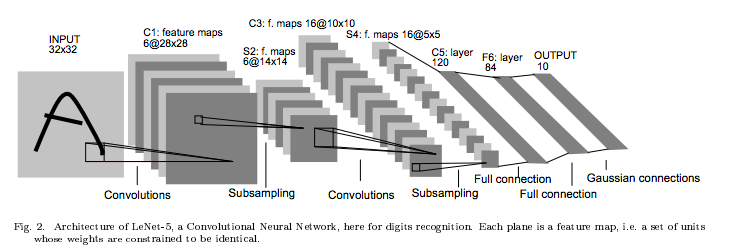



※上記論文から引用


サブサンプリングとは現在のプーリングに相当するものです。現代風に以下のように作ってみることにします。活性化関数も当時はシグモイド関数ですが、ReLUとします。


1. 畳み込み層　出力チャンネル数6、フィルタサイズ5×5、ストライド1
2. ReLU
3. 最大プーリング
4. 畳み込み層　出力チャンネル数16、フィルタサイズ5×5、ストライド1
5. ReLU
6. 最大プーリング
7. 平滑化
8. 全結合層　出力ノード数120
9. ReLU
10. 全結合層　出力ノード数84
11. ReLU
12. 全結合層　出力ノード数10
13. ソフトマックス関数

## 【問題8】（アドバンス課題）有名な画像認識モデルの調査
CNNの代表的な構造としてははAlexNet(2012)、VGG16(2014)などがあります。こういったものはフレームワークで既に用意されていることも多いです。


どういったものがあるか簡単に調べてまとめてください。名前だけでも見ておくと良いでしょう。


**《参考》**


Applications - Keras Documentation  
https://keras.io/ja/applications/*斜体テキスト*

### 8.1.1 （解答）

- Xception
- VGG16
- VGG19
- ResNet50
- InceptionV3
- InceptionResNetV2
- MobileNet
- DenseNet
- NASNet
- MobileNetV2

## 【問題9】出力サイズとパラメータ数の計算
CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要があります。


また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になってきます。フレームワークでは各層のパラメータ数を表示させることが可能ですが、意味を理解していなくては適切な調整が行えません。


以下の3つの畳み込み層の出力サイズとパラメータ数を計算してください。パラメータ数についてはバイアス項も考えてください。

In [ ]:
def calc_outshape_parameter(H, FH, W, FW, P, S, IC, OC):
    '''
    出力サイズとパラメータを計算する関数

    Parameters
    --------------
    H : int
        高さ
    FH : int
        フィルターの高さ
    W : int
        幅
    FW : int
        フィルターの幅
    P : int
        パディング
    S : int
        ストライド
    IC : int
        入力のチャンネル数
    OC : int
        出力のチャンネル数

    Returns
    ----------
    out_h : int
        出力の高さ
    out_w : int
        出力の幅
    parameter : int 
        パラメータ
    '''
    #ハイパーパラメータ
    b = 1
    
    out_h = int((H + 2 * P - FH) / S) + 1
    out_w = int((W + 2 * P - FW) / S) + 1
    parameter = (FH * FW * IC + b) * OC 
        
    print('出力サイズ(OC × OH × OW) : {} × {} × {}'.format(OC, out_h, out_w))
    print('パラメータ : {}'.format(parameter))

### 9.1.1（問題）

- 入力サイズ : 144×144, 3チャンネル
- フィルタサイズ : 3×3, 6チャンネル
- ストライド : 1
- パディング : なし

### （解答）

In [ ]:
#入力サイズ
IC, H, W = (3, 144, 144)

#フィルタサイズ
OC, FH, FW = (6, 3, 3)

#ストライド
S = 1

#パディング
P = 0

#計算
A1 = calc_outshape_parameter(H, FH, W, FW, P, S, IC, OC)
A1

### 9.2.1（問題）

- 入力サイズ : 60×60, 24チャンネル
- フィルタサイズ : 3×3, 48チャンネル
- ストライド : 1
- パディング : なし

### （解答）

In [ ]:
#入力サイズ
IC, H, W = (24, 60, 60)

#フィルタサイズ
OC, FH, FW = (48, 3, 3)

#ストライド
S = 1

#パディング
P = 0

#計算
A2 = calc_outshape_parameter(H, FH, W, FW, P, S, IC, OC)
A2

### 9.3.1（問題）

- 入力サイズ : 20×20, 10チャンネル
- フィルタサイズ : 3×3, 20チャンネル
- ストライド : 2
- パディング : なし

＊最後の例は丁度良く畳み込みをすることができない場合です。フレームワークでは余ったピクセルを見ないという処理が行われることがあるので、その場合を考えて計算してください。端が欠けてしまうので、こういった設定は好ましくないという例です。

### （解答）

In [ ]:
#入力サイズ
IC, H, W = (10, 20, 20)

#フィルタサイズ
OC, FH, FW = (20, 3, 3)

#ストライド
S = 2

#パディング
P = 0

#計算
A3 = calc_outshape_parameter(H, FH, W, FW, P, S, IC, OC)
A3

## 【問題10】（アドバンス課題）フィルタサイズに関する調査
畳み込み層にはフィルタサイズというハイパーパラメータがありますが、2次元畳み込み層において現在では3×3と1×1の使用が大半です。以下のそれぞれを調べたり、自分なりに考えて説明してください。


### 10.1.1（問題）　7×7などの大きめのものではなく、3×3のフィルタが一般的に使われる理由

### （解答） パラメータの数が膨大になるから。(サイズの2乗)

### 10.2.1（問題）　高さや幅方向を持たない1×1のフィルタの効果

### （解答） 入力チャンネルより出力チャンネルを減らすことで、パラメータを減らすことができる。